In [1]:
print("Bismillahir Rahmanir Rahim")

Bismillahir Rahmanir Rahim


## Imports and Paths

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
# https://pypi.org/project/opencv-python/
# https://opencv.org/
import cv2
from utils import plot, plt
import pandas as pd
from scipy.stats import mode

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

# 1. Deep Learning Model

## Load and preprocess data

Train/test split = 0.80/0.20

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Train and evaluate deep learning model

In [5]:
batch_size = 128
num_classes = 10
epochs = 1

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 60s 999us/step - loss: 0.2459 - acc: 0.9242 - val_loss: 0.0517 - val_acc: 0.9824
Test loss: 0.05165797256581718
Test accuracy: 0.9824


In [ ]:
# image_index = 44
# plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
# pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
# print(pred)
# print(pred.argmax())

# 2. Explanation Models

## Interpreting models using DeepExplain

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

### Define neighbohood 

In [11]:
def neighbourhood_images(x_test, y_test, digit):
    ## Find similar digit images to use as neighbourhood
    indices = []
    index = 0
    for label_array in y_test:
        label = np.argmax(label_array)
        if label == digit:
            indices.append(index)
        index = index +1
    x_test_neighborhood = x_test[indices]
    y_test_neighborhood = y_test[indices]
    return x_test_neighborhood, y_test_neighborhood

In [244]:
digit = 7
anchor_index = 0
x_test_neighborhood, y_test_neighborhood = neighbourhood_images(x_test, y_test, digit)
print(y_test_neighborhood[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### Interpreting models using DeepExplain

In [245]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test_neighborhood
    ys = y_test_neighborhood
    
    attributions_sal = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print('Digit ', digit)
    print ("Done")

Digit  7
Done
CPU times: user 16min 21s, sys: 3min 32s, total: 19min 54s
Wall time: 3min 34s


### Explanation calculation time

- Digit 3: CPU times: user 12min 43s, sys: 2min 25s, total: 15min 9s, Wall time: 2min 43s

- Digit  7: CPU times: user 13min 30s, sys: 2min 31s, total: 16min 2s, Wall time: 2min 50s

### Measuring stability using lipschitz estimation

In [246]:
def euclidean_distances(x0, Xs):
    distances = []
    for image in Xs:
        df = np.asarray(x0 - image)  # the difference between the images
        dst = np.sqrt(np.sum(df**2))
        distances.append(dst)
    return distances

In [247]:
def lipschitz_estimation(anchor_index, x_test_neighborhood_exp):
    
    neighborhood_size = len(x_test_neighborhood)
    filter_indices = np.arange(0, neighborhood_size)
    filter_indices = np.delete(filter_indices, anchor_index)

    anchorX = x_test_neighborhood[anchor_index]
    anchorX_exp = x_test_neighborhood_exp[anchor_index]
    
    nearby_points = x_test_neighborhood[filter_indices]
    nearby_points_exp = x_test_neighborhood_exp[filter_indices]

    anchorX_norm2 = euclidean_distances(anchorX, nearby_points)
    anchorX_exp_norm2 = euclidean_distances(anchorX_exp, nearby_points_exp)

    anchorX_avg_norm2 = np.divide(anchorX_exp_norm2, anchorX_norm2)
    anchorX_LC_argmax = np.argmax(anchorX_avg_norm2)
    
    return anchorX_LC_argmax, anchorX_avg_norm2

In [248]:
col_lipschitz = ['digit','image_instance','anchor_index','neighborhood_size',
                 'image_instance_exp', 'deviation_indices', 'lc_coefficents',
                 'deviation_image_instances', 'deviation_image_instance_exp']

In [249]:
def lipschitz_estimates_to_dataframe(explanations):
    
    digits = []
    image_instance  = []
    anchor_indices  = []
    neighborhood_size = []
    image_instance_exp = dict()
    deviation_indices = dict()
    lc_coefficents = dict()
    deviation_image_instance  = []
    deviation_image_instances  = dict()
    deviation_image_instance_exp = dict()

    for key, arrtibutions in explanations.items():
        # calculate lipschitz estimation
        anchorX_LC_argmax, anchorX_avg_norm2 = lipschitz_estimation(anchor_index, arrtibutions)

        digits.append(digit)
        image_instance.append(x_test_neighborhood[anchor_index])
        anchor_indices.append(anchor_index)
        neighborhood_size.append(len(x_test_neighborhood)-1)

        # add explanation of anchor_image by key=model_name
        image_instance_exp[key] = arrtibutions[anchor_index]
        
        # add worst deviation_index using it gives the lipschitz estimate   
        key_deviation_index = 'deviation_index'
        deviation_indices[key] = {key_deviation_index: anchorX_LC_argmax}
        argmax_lc_coefficent = anchorX_avg_norm2[anchorX_LC_argmax]
        
        # add lipschitz estimate value by key=model_name
        key_lc_coefficent = 'lc_coefficent_' + key
        lc_coefficents[key] = {key_lc_coefficent: argmax_lc_coefficent}
        
        # add deviation image instance
        deviation_image_instances[key] = x_test_neighborhood[anchorX_LC_argmax]
        
        # add deviation explanation correspond to anchor_image by key=model_name
        deviation_image_instance_exp[key] = arrtibutions[anchorX_LC_argmax]

    devi_index = []
    for key, value in deviation_indices.items():
        devi_index.append(value['deviation_index'])
    dv_mode = mode(devi_index)
    dv_index = dv_mode[0][0]
    print('Most frequent deviation index in lipschitz calculations', dv_index)
    
    for key, arrtibutions in explanations.items():
        
        # add deviation image instance
        deviation_image_instance.append(x_test_neighborhood[dv_index])
        
#         # add deviation explanation correspond to anchor_image by key=model_name
#         deviation_image_instance_exp[key] = arrtibutions[dv_index]
        
    zippedList = list(zip(digits, image_instance, anchor_indices, neighborhood_size,
                          [image_instance_exp], [deviation_indices], [lc_coefficents],
                          [deviation_image_instances], [deviation_image_instance_exp]))
        
    df = pd.DataFrame(zippedList, columns=col_lipschitz)
    return df

In [250]:
exp_models = ['Saliency', 'Grad*input', 'e-LRP', 'Occlusion', 'Deeplift']
exp_attributions = [attributions_sal, attributions_gradin, attributions_elrp, attributions_occ, attributions_dl]
explanations = dict(zip(exp_models, exp_attributions))

In [251]:
# cnn_lipschitz = lipschitz_estimates_to_dataframe(explanations)
cnn_lipschitz_7 = lipschitz_estimates_to_dataframe(explanations)

Most frequent deviation index in lipschitz calculations 418


In [252]:
display(cnn_lipschitz.head())
display(cnn_lipschitz_7.head())

,digit,image_instance,anchor_index,neighborhood_size,image_instance_exp,deviation_indices,lc_coefficents,deviation_image_instances,deviation_image_instance_exp
0,3,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....",0,1009,"{'Saliency': [[[0.0007595], [0.00037728], [0.0...","{'Saliency': {'deviation_index': 294}, 'Grad*i...",{'Saliency': {'lc_coefficent_Saliency': 0.1025...,"{'Saliency': [[[-1.], [-1.], [-1.], [-1.], [-1...","{'Saliency': [[[0.000789], [0.00029105], [0.00..."


,digit,image_instance,anchor_index,neighborhood_size,image_instance_exp,deviation_indices,lc_coefficents,deviation_image_instances,deviation_image_instance_exp
0,7,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....",0,1027,"{'Saliency': [[[0.00179095], [0.00136184], [0....","{'Saliency': {'deviation_index': 418}, 'Grad*i...",{'Saliency': {'lc_coefficent_Saliency': 0.1572...,"{'Saliency': [[[-1.], [-1.], [-1.], [-1.], [-1...","{'Saliency': [[[0.00215252], [0.00175184], [0...."


In [253]:
# deviation_image_instance_exp = cnn_lipschitz_7['deviation_image_instance_exp'][0]
# deviation_image_instance_exp.get('Saliency')
# type(deviation_image_instance_exp)

In [254]:
image_instance = cnn_lipschitz['image_instance'][0]
images = {'Original': image_instance}
image_instance_exp = cnn_lipschitz['image_instance_exp'][0]
# value = image_instance_exp['Saliency']
# images.update({'Saliency': value})
images.update(image_instance_exp)

for key, instance in images.items():
    print(key)
#     print(dv_key)

Original
Saliency
Grad*input
e-LRP
Occlusion
Deeplift


### Worst-case deviation visualisation

In [255]:
# %%time
# from utils import plot, plt
# %matplotlib inline

# n_cols = 2
# n_rows = 2 # int(len(attributions_gradin[:10]) / 2)
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

# for i, (a1) in enumerate(zip(attributions_gradin[:4])):
#     row, col = divmod(i, 2)
#     print(row)
#     print(col)
# #     plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
# #     plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
# #     plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')

dict_keys(['Original', 'Deviation', 'Occlusion', 'Occlusion_Deviation_Instance'])
[[2.1029341e-03 3.3567334e-03 1.0946929e-02 4.4800833e-02 9.6073745e-05
  1.3495743e-03 4.6469062e-04 8.0185175e-01 3.8266010e-03 1.3120393e-01]]




Text(0.4, 0.004, 'Occlusion')

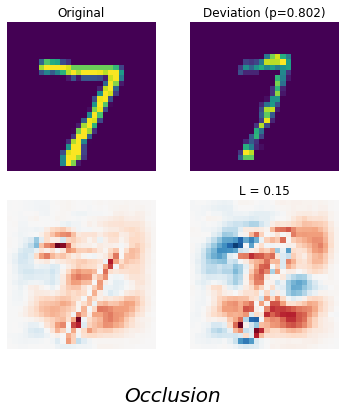

In [262]:
# model_name = 'Saliency'
# model_name = 'Grad*input'
# model_name = 'e-LRP'
model_name = 'Occlusion'
# model_name = 'Deeplift'

data = cnn_lipschitz_7

images = dict()
image_instance = data['image_instance'][0]
images.update({'Original': image_instance})
deviation_image_instance = data['deviation_image_instances'][0][model_name]
images.update({'Deviation': deviation_image_instance})

image_instance_exp = data['image_instance_exp'][0]
value = image_instance_exp[model_name]
images.update({model_name: value})

deviation_image_instance_exp = data['deviation_image_instance_exp'][0]
value = deviation_image_instance_exp[model_name]
new_key = model_name + '_Deviation_Instance'
images.update({new_key: value})

print(images.keys())

n_cols = 2
n_rows = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

ax = 0
for key, instance in images.items():
    row, col = divmod(ax, 2)
    if key == 'Original':
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col]).set_title(key)
    
    elif key ==  'Deviation':
        pred = model.predict(instance.reshape(1, 28, 28, 1))
        print(pred)
        print()
        print()
        axis = plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col])
        pred_prb = str(round(pred[0][pred.argmax()], 3))
        title = key + ' (p=' + pred_prb +')'
        axis.set_title(title)

    elif key == model_name + '_Deviation_Instance':
        lc = cnn_lipschitz['lc_coefficents'][0][model_name]
        lc_key = 'lc_coefficent_' + model_name
        key = 'L = {}'.format(str(round(lc[lc_key], 2)))
        plot(instance.reshape(28,28), axis=axes[row, col]).set_title(key)
    
    else:
        plot(instance.reshape(28,28), axis=axes[row, col])
    ax = ax + 1
    
# for axes in axes.flat:
#     axes.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for axes in axes.flat:
#     axes.label_outer()
    
fig.text(0.4, 0.004, model_name , fontsize=20, fontstyle='italic')

CPU times: user 177 ms, sys: 3.32 ms, total: 180 ms
Wall time: 178 ms


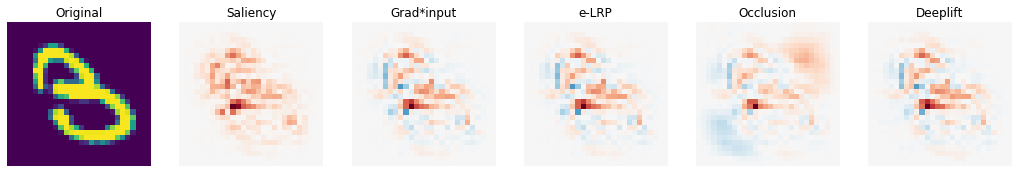

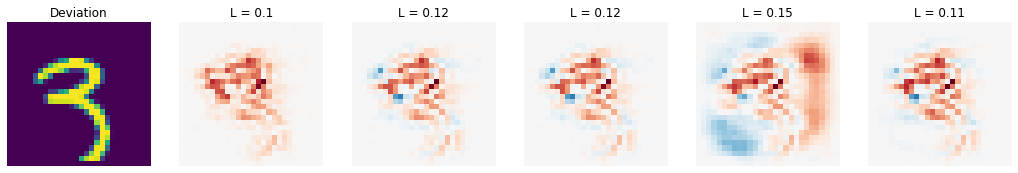

In [40]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
ax = 0

image_instance = cnn_lipschitz['image_instance'][0]
images = {'Original': image_instance}
image_instance_exp = cnn_lipschitz['image_instance_exp'][0]
images.update(image_instance_exp)

for key, instance in images.items():
    if ax == 0:
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
    else:
        plot(instance.reshape(28,28), axis=axes[ax]).set_title(key)
    ax = ax + 1
    


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
ax = 0

deviation_image_instance = cnn_lipschitz['deviation_image_instance'][0]
images = {'Deviation': deviation_image_instance}
deviation_image_instance_exp = cnn_lipschitz['deviation_image_instance_exp'][0]
images.update(deviation_image_instance_exp)

for key, instance in images.items():
    if ax == 0:
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
    else:
        lc = cnn_lipschitz['lc_coefficents'][0][key]
        lc_key = 'lc_coefficent_' + key
        dv_key = 'L = {}'.format(str(round(lc[lc_key], 2)))
        plot(instance.reshape(28,28), axis=axes[ax]).set_title(dv_key)
    ax = ax + 1

CPU times: user 164 ms, sys: 6.31 ms, total: 170 ms
Wall time: 168 ms


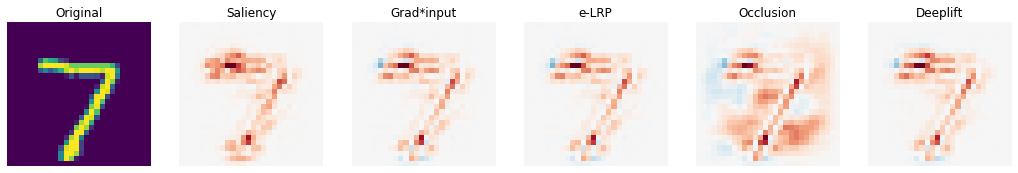

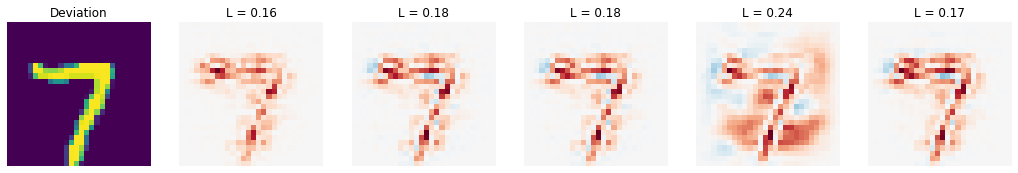

In [41]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
ax = 0

image_instance = cnn_lipschitz_7['image_instance'][0]
images = {'Original': image_instance}
image_instance_exp = cnn_lipschitz_7['image_instance_exp'][0]
images.update(image_instance_exp)

for key, instance in images.items():
    if ax == 0:
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
    else:
        plot(instance.reshape(28,28), axis=axes[ax]).set_title(key)
    ax = ax + 1
    


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
ax = 0

deviation_image_instance = cnn_lipschitz_7['deviation_image_instance'][0]
images = {'Deviation': deviation_image_instance}
deviation_image_instance_exp = cnn_lipschitz_7['deviation_image_instance_exp'][0]
images.update(deviation_image_instance_exp)

for key, instance in images.items():
    if ax == 0:
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
    else:
        lc = cnn_lipschitz_7['lc_coefficents'][0][key]
        lc_key = 'lc_coefficent_' + key
        dv_key = 'L = {}'.format(str(round(lc[lc_key], 2)))
        plot(instance.reshape(28,28), axis=axes[ax]).set_title(dv_key)
    ax = ax + 1

### Boxplot visualisation of lipschitz estimation on 100 image instances

### Adding guassian noise

1) https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a

In [82]:
import math

# value = str('1.1118e-02')
# value2 = value.replace(',', '.')
# float(value2)

(28, 28, 1)


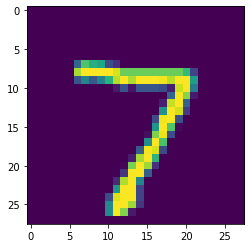

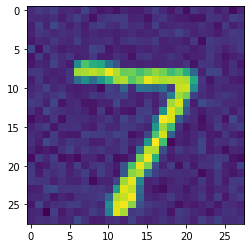

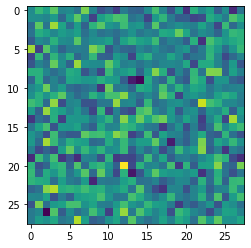

In [81]:
mean = 0
sigma = 0.1
gaussian = np.random.normal(mean, sigma, (28, 28)) #  np.zeros((28, 28), np.float32)

noisy_image = np.zeros(img.shape, np.float32)
print(noisy_image.shape)
noisy_image[:, :, 0] = img[:, :, 0] + gaussian
cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
noisy_image = noisy_image.astype(np.uint8)

pixels = img.reshape((28, 28))
plt.imshow(pixels)
plt.show()

pixels = noisy_image.reshape((28, 28))
plt.imshow(pixels)
plt.show()

pixels = gaussian.reshape((28, 28))
plt.imshow(pixels)
plt.show()

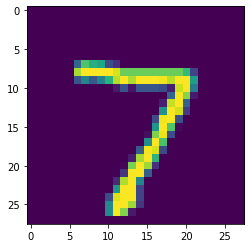

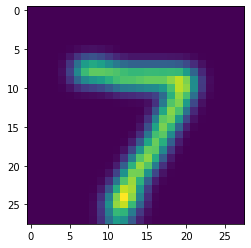

In [43]:
img = x_test[0]
img = np.array(img, dtype='float')

noisy_image = cv2.GaussianBlur(img, (5, 5), 0)
cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
noisy_image = noisy_image.reshape((28, 28, 1))
noisy_image = noisy_image.astype(np.uint8)

pixels = img.reshape((28, 28))
plt.imshow(pixels)
plt.show()

# noisy_img_clipped = np.clip(noisy_image, 0, 255)
pixels = noisy_image.reshape((28, 28))
plt.imshow(pixels)
plt.show()

In [158]:
# matplt.imshow(np.vstack((np.hstack((img, noisy_image)))))
# matplt.show()

# cv2.imshow("img", img)
# cv2.imshow("gaussian", gaussian)
# cv2.imshow("noisy", noisy_image)

# cv2.waitKey(0)

In [ ]:

# explanations = [img, sal, gradin, elrp, occ, occ]
# i = 0
# for image in explanations:
# #     row, col = divmod(i, 2)
# #     print("row", i)
# #     print(col)
# #     print(i)
#     plot(image.reshape(28,28), axis=axes[i]).set_title('saliency')
# #     plot(a2.reshape(28,28), axis=axes[i]).set_title('Grad*Input')
#     i = i + 1

    
# for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_sal)):
#     row, col = divmod(i, 2)
#     print(row)
#     print(col)
#     plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
# #     plot(xs[i].reshape(28, 28), axis=axes[row, col*3]).set_title('Original')
#     plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')    
#     plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('saliency')

### Set instances, explanations and epsilon choices

In [37]:
X = pd.DataFrame(test)
display(X.head().values)
x_points = X.copy().values

radii = [1.00]
# radii = [0.75, 1.00, 1.25]

array([[5.1, 3.4, 1.5, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [7.2, 3.6, 6.1, 2.5],
       [6.3, 2.7, 4.9, 1.8],
       [6.7, 3. , 5. , 1.7]])

### Lipschitz  estimations
    Predictive model: random forest
    Explanation methods: LIME, SHAP

In [40]:
print("LIME generated explanations")
X_lime_exp = explanations_lime_rf.iloc[:,:-1].copy()
display(X_lime_exp.head())

print("SHAP generated explanations")
X_shap_exp = explanations_shap_rf.iloc[:,:].copy()
display(X_shap_exp.head())

LIME generated explanations


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.029378,0.014655,0.427538,0.433357
1,0.003731,0.008241,-0.039195,-0.069708
2,0.034853,-0.005104,0.401783,0.487102
3,-0.028999,-0.011783,0.019920,0.032801
4,0.020741,-0.000242,0.004176,0.037995


SHAP generated explanations


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.067061,0.002869,0.294490,0.302247
1,0.067061,0.002869,0.294490,0.302247
2,0.066648,-0.001801,0.308798,0.291021
3,0.029199,-0.004630,0.125006,0.407091
4,0.042772,0.009896,0.176799,0.155200


In [41]:
x_points_lime_exp = X_lime_exp.copy().values
x_points_shap_exp = X_shap_exp.copy().values

In [42]:
zippedList, columns_lipschitz = find_lipschitz_estimates(x_points,
                                                         x_points_lime_exp,
                                                         x_points_shap_exp,
                                                         radii)
rf_lipschitz = pd.DataFrame(zippedList, columns=columns_lipschitz)

In [473]:
display(rf_lipschitz)

,instance,anchor_x_index,lc_coefficient_lime,x_deviation_index_lime,lc_coefficient_shap,x_deviation_index_shap,radiuses,neighborhood_size
0,"[5.1, 3.4, 1.5, 0.2]",0,2.803608,1,0.203645,11,1.0,8
1,"[5.0, 3.4, 1.6, 0.4]",1,2.803608,0,0.149435,11,1.0,8
2,"[7.2, 3.6, 6.1, 2.5]",2,0.018179,13,0.025685,8,1.0,6
3,"[6.3, 2.7, 4.9, 1.8]",3,0.690476,24,0.496384,4,1.0,10
4,"[6.7, 3.0, 5.0, 1.7]",4,1.002488,7,0.515260,16,1.0,9
5,"[4.8, 3.4, 1.9, 0.2]",5,1.228719,1,0.100752,11,1.0,8
6,"[5.1, 3.5, 1.4, 0.2]",6,2.190506,1,0.225513,11,1.0,8
7,"[6.9, 3.1, 5.4, 2.1]",7,1.002488,4,0.327276,4,1.0,8
8,"[6.7, 3.3, 5.7, 2.5]",8,0.548146,21,0.025685,2,1.0,6
9,"[6.3, 3.3, 4.7, 1.6]",9,0.565687,27,0.672070,27,1.0,7


# 4. Results

## a. Selecting anchor point or point of interest to demonstrate results

Here the selection is made based on max 'lc_coefficient_lime' just to take an example point.

### Anchor point

In [468]:
highest_deviation_example = rf_lipschitz.loc[rf_lipschitz['lc_coefficient_lime'].idxmax()]
display(highest_deviation_example)

print("Anchor Point")
anchor_point_index = highest_deviation_example["anchor_x_index"]
anchor_point = highest_deviation_example['instance']
print(anchor_point)

instance                  [5.1, 3.4, 1.5, 0.2]
anchor_x_index                               0
lc_coefficient_lime                    2.80361
x_deviation_index_lime                       1
lc_coefficient_shap                   0.203645
x_deviation_index_shap                      11
radiuses                                     1
neighborhood_size                            8
Name: 0, dtype: object

Anchor Point
[5.1 3.4 1.5 0.2]


### Deviation point with respect to LIME explanation

In [470]:
print("\nDeviation Point with respect to LIME explanation")
deviation_point_lime_index = highest_deviation_example["x_deviation_index_lime"]
deviation_point_lime = rf_lipschitz['instance'][deviation_point_lime_index]
print(deviation_point_lime)


Deviation Point with respect to LIME explanation
[5.  3.4 1.6 0.4]


### Deviation point with respect to SHAP explanation

In [472]:
print("\nDeviation Point with respect to SHAP explanation")
deviation_point_shap_index = highest_deviation_example["x_deviation_index_shap"]
deviation_point_shap = rf_lipschitz['instance'][deviation_point_shap_index]
print(deviation_point_shap)


Deviation Point with respect to SHAP explanation
[5.5 3.5 1.3 0.2]


### Anchor point and deviation point LIME explanation

In [474]:
print("Anchor Point LIME explanation")
anchor_point_lime_exp = x_points_lime_exp[anchor_point_index]
anchor_point_lime_exp = [ round(elem, 3) for elem in anchor_point_lime_exp ]
print(anchor_point_lime_exp)

print("\nDeviation Point LIME explanation")
deviation_point_lime_exp = x_points_lime_exp[deviation_point_lime_index]
deviation_point_lime_exp = [ round(elem, 3) for elem in deviation_point_lime_exp ]
print(deviation_point_lime_exp)

Anchor Point LIME explanation
[0.029, 0.015, 0.428, 0.433]

Deviation Point LIME explanation
[0.004, 0.008, -0.039, -0.07]


### Anchor point and deviation point SHAP explanation

In [475]:
print("Anchor Point SHAP explanation")
anchor_point_shap_exp = x_points_shap_exp[anchor_point_index]
anchor_point_shap_exp = [ round(elem, 3) for elem in anchor_point_shap_exp ]
print(anchor_point_shap_exp)

print("\nDeviation Point SHAP explanation")
deviation_point_shap_exp = x_points_shap_exp[deviation_point_shap_index]
deviation_point_shap_exp = [ round(elem, 3) for elem in deviation_point_shap_exp ]
print(deviation_point_shap_exp)

Anchor Point SHAP explanation
[0.067, 0.003, 0.294, 0.302]

Deviation Point SHAP explanation
[-0.023, 0.003, 0.312, 0.319]


## b. Preparing results for box plots
    Predictive model: random forest
    Epsilon: 1.00
    Explanation methods: LIME, SHAP
    Evaluation: Lipschitz estimations as stability

In [283]:
epsilon1 = rf_lipschitz.loc[rf_lipschitz['neighborhood_size'] > 0]
epsilon1 = epsilon1[epsilon1['radiuses'] == 1.00]
display(epsilon1.head())

,instance,anchor_x_index,lc_coefficient_lime,x_deviation_index_lime,lc_coefficient_shap,x_deviation_index_shap,radiuses,neighborhood_size
0,"[5.1, 3.4, 1.5, 0.2]",0,2.803608,1,0.203645,11,1.0,8
1,"[5.0, 3.4, 1.6, 0.4]",1,2.803608,0,0.149435,11,1.0,8
2,"[7.2, 3.6, 6.1, 2.5]",2,0.018179,13,0.025685,8,1.0,6
3,"[6.3, 2.7, 4.9, 1.8]",3,0.690476,24,0.496384,4,1.0,10
4,"[6.7, 3.0, 5.0, 1.7]",4,1.002488,7,0.515260,16,1.0,9


In [286]:
epsilon1_lc_lime_aggre = np.mean(epsilon1['lc_coefficient_lime'])
epsilon1_lc_shap_aggre = np.mean(epsilon1['lc_coefficient_shap'])
print("\nLIME, epsilon 1.00, Aggregated L(x) = ", epsilon1_lc_lime_aggre)
print("SHAP, epsilon 1.00, Aggregated L(x) = ", epsilon1_lc_shap_aggre)


LIME, epsilon 1.00, Aggregated L(x) =  0.929153143708511
SHAP, epsilon 1.00, Aggregated L(x) =  0.24586400627509725


In [287]:
lc_lime_df = epsilon1.loc[:, ['lc_coefficient_lime']]
lc_lime_df.rename(columns={'lc_coefficient_lime': 'Lipschitz Estimates'}, inplace=True)
lc_lime_df['method'] = 'LIME'
lc_lime_df['Dataset'] = 'Iris'

lc_shap_df = epsilon1.loc[:, ['lc_coefficient_shap']]
lc_shap_df.rename(columns={'lc_coefficient_shap': 'Lipschitz Estimates'}, inplace=True)
lc_shap_df['method'] = 'SHAP'
lc_shap_df['Dataset'] = 'Iris'

# 5. Visualize Results

### Highest deviation example and corresponding LIME and SHAP examples

In [507]:
print(feature_names)

print('\nAnchor Point in worst deviation case')
print(anchor_point)
print(anchor_point_lime_exp)
print(anchor_point_shap_exp)

print('\nDeviation Point in LIME explanation')
print(deviation_point_lime)
print(deviation_point_lime_exp)

print('\nDeviation Point in SHAP explanation')
print(deviation_point_shap)
print(deviation_point_shap_exp)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Anchor Point in worst deviation case
[5.1 3.4 1.5 0.2]
[0.029, 0.015, 0.428, 0.433]
[0.067, 0.003, 0.294, 0.302]

Deviation Point in LIME explanation
[5.  3.4 1.6 0.4]
[0.004, 0.008, -0.039, -0.07]

Deviation Point in SHAP explanation
[5.5 3.5 1.3 0.2]
[-0.023, 0.003, 0.312, 0.319]


## Final plot to explain deviation as unstability in explanations

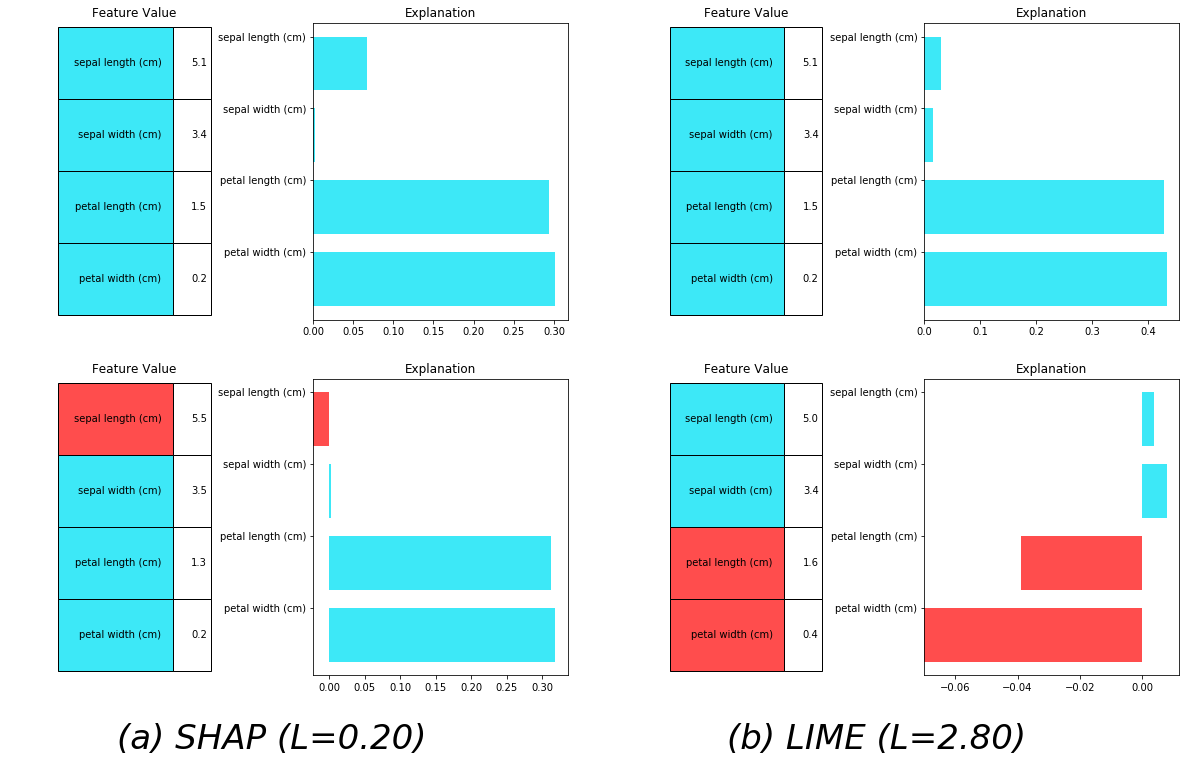

In [542]:
# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
threshold = 0

fig, axs = plt.subplots(2, 4)
# fig.set_size_inches(20.5, 12.5)
fig.set_size_inches(21, 12)


# position axs[0, 0]
axs[0, 0].set_title('Feature Value')
colors = [["#3DE8F7","w"],[ "#3DE8F7","w"], [ "#3DE8F7","w"], [ "#3DE8F7","w"]]
anchor_point_dict = dict(zip(feature_names, anchor_point))
anchor_point_df = pd.DataFrame.from_dict(anchor_point_dict, orient='index').reset_index()
table = axs[0, 0].table(
    cellText = anchor_point_df.values,
    loc = 'center',
    cellColours = colors,
    colWidths=[0.3] * 2)
table.set_fontsize(12)
table.scale(1.5,6)
cellDict = table.get_celld()
cellDict[(0,1)].set_width(0.15)
cellDict[(1,1)].set_width(0.15)
cellDict[(2,1)].set_width(0.15)
cellDict[(3,1)].set_width(0.15)
axs[0, 0].axis('off')
axs[0, 0].axis('tight')


# position axs[0, 1]
axs[0, 1].set_title('Explanation')
x = feature_names[::-1]
y = np.array(anchor_point_shap_exp[::-1]) # anchor_point_shap_exp
# print(x, y)
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
above_threshold = np.maximum(y - threshold, 0)
below_threshold = np.minimum(y, threshold)
axs[0, 1].barh(x, below_threshold, width, color="#FF4D4D") # below threshold value
axs[0, 1].barh(x, above_threshold, width, color="#3DE8F7", left=below_threshold) # above threshold value
axs[0, 1].set_yticks(ind+width/2)


# position axs[0, 2]
axs[0, 2].set_title('Feature Value')
colors = [["#3DE8F7","w"],[ "#3DE8F7","w"], [ "#3DE8F7","w"], [ "#3DE8F7","w"]]
anchor_point_dict = dict(zip(feature_names, anchor_point))
anchor_point_df = pd.DataFrame.from_dict(anchor_point_dict, orient='index').reset_index()
table = axs[0, 2].table(
    cellText = anchor_point_df.values,
    loc = 'center',
    cellColours = colors,
    colWidths=[0.3] * 2)
table.set_fontsize(12)
table.scale(1.5,6)
cellDict = table.get_celld()
cellDict[(0,1)].set_width(0.15)
cellDict[(1,1)].set_width(0.15)
cellDict[(2,1)].set_width(0.15)
cellDict[(3,1)].set_width(0.15)
axs[0, 2].axis('off')
axs[0, 2].axis('tight')


# position axs[0, 3]
axs[0, 3].set_title('Explanation')
x = feature_names[::-1]
y = np.array(anchor_point_lime_exp[::-1]) # # anchor_point_lime_exp
# print(x, y)
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
above_threshold = np.maximum(y - threshold, 0)
below_threshold = np.minimum(y, threshold)
# ax.barh(ind, y, width, color="#3DE8F7")
axs[0, 3].barh(x, below_threshold, width, color="#FF4D4D") # below threshold value
axs[0, 3].barh(x, above_threshold, width, color="#3DE8F7", left=below_threshold) # above threshold value
axs[0, 3].set_yticks(ind+width/2)




# position axs[1, 0]
axs[1, 0].set_title('Feature Value')
colors = [["#FF4D4D","w"],[ "#3DE8F7","w"], [ "#3DE8F7","w"], [ "#3DE8F7","w"]]
deviation_point_dict = dict(zip(feature_names, deviation_point_shap)) # deviation_point_shap
deviation_point_df = pd.DataFrame.from_dict(deviation_point_dict, orient='index').reset_index()
table = axs[1, 0].table(
    cellText = deviation_point_df.values,
    loc = 'center',
    cellColours = colors,
    colWidths=[0.3] * 2)
table.set_fontsize(12)
table.scale(1.5,6)
cellDict = table.get_celld()
cellDict[(0,1)].set_width(0.15)
cellDict[(1,1)].set_width(0.15)
cellDict[(2,1)].set_width(0.15)
cellDict[(3,1)].set_width(0.15)
axs[1, 0].axis('off')
axs[1, 0].axis('tight')


# position axs[1, 1]
axs[1, 1].set_title('Explanation')
x = feature_names[::-1]
y = np.array(deviation_point_shap_exp[::-1]) # deviation_point_shap_exp
# print(x, y)
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
above_threshold = np.maximum(y - threshold, 0)
below_threshold = np.minimum(y, threshold)
# ax.barh(ind, y, width, color="#3DE8F7")
axs[1, 1].barh(x, below_threshold, width, color="#FF4D4D") # below threshold value
axs[1, 1].barh(x, above_threshold, width, color="#3DE8F7", left=below_threshold) # above threshold value
axs[1, 1].set_yticks(ind+width/2)


# position axs[1, 2]
axs[1, 2].set_title('Feature Value')
colors = [["#3DE8F7","w"],[ "#3DE8F7","w"], [ "#FF4D4D","w"], [ "#FF4D4D","w"]]
deviation_point_dict = dict(zip(feature_names, deviation_point_lime)) # deviation_point_lime
deviation_point_df = pd.DataFrame.from_dict(deviation_point_dict, orient='index').reset_index()
table = axs[1, 2].table(
    cellText = deviation_point_df.values,
    loc = 'center',
    cellColours = colors,
    colWidths=[0.3] * 2)
table.set_fontsize(12)
table.scale(1.5,6)
cellDict = table.get_celld()
cellDict[(0,1)].set_width(0.15)
cellDict[(1,1)].set_width(0.15)
cellDict[(2,1)].set_width(0.15)
cellDict[(3,1)].set_width(0.15)
axs[1, 2].axis('off')
axs[1, 2].axis('tight')


# position axs[1, 3]
axs[1, 3].set_title('Explanation')
x = feature_names[::-1]
y = np.array(deviation_point_lime_exp[::-1]) # deviation_point_lime_exp
# print(x,y)
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
above_threshold = np.maximum(y - threshold, 0)
below_threshold = np.minimum(y, threshold)
# ax.barh(ind, y, width, color="#3DE8F7")
axs[1, 3].barh(x, below_threshold, width, color="#FF4D4D") # below threshold value
axs[1, 3].barh(x, above_threshold, width, color="#3DE8F7", left=below_threshold) # above threshold value
axs[1, 3].set_yticks(ind+width/2)

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# fig.suptitle('(a) SHAP (L=0.2)', fontsize=16)

fig.text(0.3, 0.04, '(a) SHAP (L=0.20)', ha='center', fontsize=34, fontstyle='italic')
fig.text(0.7, 0.04, '(b) LIME (L=2.80)', ha='center', fontsize=34, fontstyle='italic')

fig.savefig(plots_path + 'experiments_figure1.png')

### Visualize lipschitz estimations for all test instances

In [505]:
box_plot_df = lc_lime_df.append(lc_shap_df)

In [509]:
filename = 'iris_box_plot_df.csv'
box_plot_df.to_csv(generate_csv_path + filename, index=True)

[None]

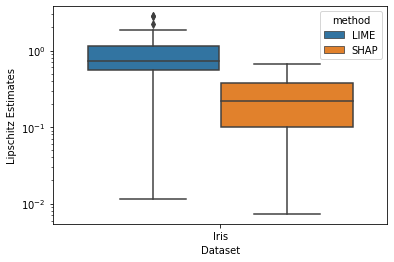

In [503]:
box_plot = sns.boxplot(x="Dataset", y="Lipschitz Estimates", hue="method", data=box_plot_df)
box_plot.set(yscale="log")
# sns.despine(offset=10, trim=True)

### Visualize lipschitz estimations for all test instances from UCI classification datasets

In [517]:
iris_box_plot_df = box_plot_df.copy()
iono_box_plot_df = pd.read_csv(generate_csv_path + "iono_box_plot_df.csv", index_col=0)
glass_box_plot_df = pd.read_csv(generate_csv_path + "glass_box_plot_df.csv", index_col=0)

box_plots = iris_box_plot_df.append(iono_box_plot_df)
box_plots = box_plots.append(glass_box_plot_df)

# display(box_plots.head())
# display(box_plots.tail())

,Lipschitz Estimates,method,Dataset
0,2.803608,LIME,Iris
1,2.803608,LIME,Iris
2,0.018179,LIME,Iris
3,0.690476,LIME,Iris
4,1.002488,LIME,Iris


,Lipschitz Estimates,method,Dataset
38,0.009346,SHAP,Glass
39,0.072976,SHAP,Glass
40,0.034557,SHAP,Glass
41,0.055203,SHAP,Glass
42,0.088517,SHAP,Glass


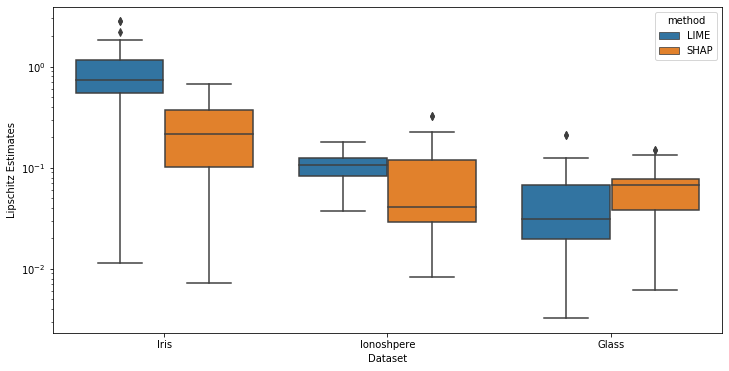

In [527]:
plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x="Dataset", y="Lipschitz Estimates", hue="method", data=box_plots)
box_plot.set(yscale="log")
plt.savefig(plots_path + 'experiments_figure2.png')

### Exploring section
    Does not include in work

### LIME visualizations by single points

In [ ]:
explainer_lime = LimeTabularExplainer(train,
                                      mode = 'classification',
                                      training_labels = labels_train,
                                      feature_names=feature_names,
                                      verbose=False,
                                      class_names=target_names,
                                      feature_selection='auto',
                                      discretize_continuous=True)

In [ ]:

x_instance = test[anchor_index]
LR_exp_lime = explainer_lime.explain_instance(x_instance,
                                                 LR_iris.predict_proba,
                                                 labels=np.unique(iris.target),
                                                 top_labels=None,
                                                 num_features=len(x_instance),
                                                 num_samples=6000)

In [ ]:
LR_exp_lime.show_in_notebook()

In [ ]:
x_instance = test[similar_point_index]
LR_exp_lime = explainer_lime.explain_instance(x_instance,
                                                 LR_iris.predict_proba,
                                                 labels=np.unique(iris.target),
                                                 top_labels=None,
                                                 num_features=len(x_instance),
                                                 num_samples=6000)

In [ ]:
LR_exp_lime.show_in_notebook()

In [ ]:
i = np.random.randint(0, test.shape[0])
i = 0

LR_exp_lime_map = LR_exp_lime.as_map()
# pprint(LR_exp_lime_map)

print('Predicted class for i:', labels_pred_lr[i])
LR_exp_lime_list = LR_exp_lime.as_list(label=labels_pred_lr[i])
# pprint(LR_exp_lime_list)

## Conclusions

In [ ]:
lr_lime_iris = [2.657, 3.393, 1.495]
rf_lime_iris = [3.010, 3.783, 1.767]
lr_shap_iris = [2.716, 3.512, 1.463]
rf_shap_iris = [1.969, 3.546, 2.136]

In [ ]:
find_min_vector = np.array([lr_lime_iris, rf_lime_iris, lr_shap_iris, rf_shap_iris])
np.amin(find_min_vector, axis=0)

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = Ridge(alpha=1.0)
clf.fit(X, y)

### Debuging Space

In [ ]:
""" Use euclidean distance to define neighborhood points
"""
display(X.head())
points = X.values
epsilon = 0.75 * np.sqrt(len(points[0]))

dist = (points[0] - points[1:])**2
dist = np.sum(dist, axis=1)
dist = np.sqrt(dist)
print(dist)
neighborhood_indices = []
for index in range(0, len(dist)):
    if dist[index] < epsilon:
        neighborhood_indices.append(index)
print(neighborhood_indices)